# Univariate Density Estimation via Dirichlet Process Mixture

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pybmix.core.mixing import DirichletProcessMixing, StickBreakMixing
from pybmix.core.hierarchy import UnivariateNormal
from pybmix.core.mixture_model import MixtureModel

np.random.seed(2021)

## Data Generation

We generate data from a two-component mixture model
$$
y_i \sim \frac{1}{2} \mathcal N(-3, 1) + \frac{1}{2} \mathcal N(3, 1), \quad i=1, \ldots, 200
$$

In [2]:
def sample_from_mixture(weigths, means, sds, n_data):
    n_comp = len(weigths)
    clus_alloc = np.random.choice(np.arange(n_comp), p=[0.5, 0.5], size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

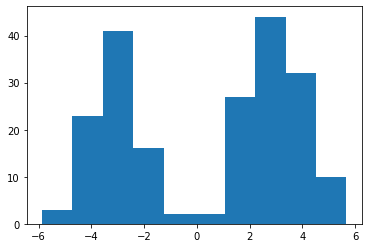

In [3]:
y = sample_from_mixture(
    np.array([0.5, 0.5]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y)
plt.show()

## The statistical model

We assume the following model

\begin{equation}
\begin{aligned}
y_i | \tilde{p} &\sim f(\cdot) = \int_{R \times R^+} \mathcal{N}(\cdot | \mu, \sigma^2) \tilde{p}(d\mu, d\sigma^2) \\
\tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}

where $DP(\alpha, G_0)$ is the Dirichlet Process with base measure $\alpha G_0$. 

Given the stick-breaking represetation of the Dirichlet Process, the model is equivalently written as

\begin{equation}
\begin{aligned}
y_i | \{w_h\}_h \{(\mu_h, \sigma^2_h)\}_h & \sim f(\cdot) = \sum_{h=1}^\infty w_h \mathcal{N}(\cdot | \mu_h, \sigma_h^2) \\
\{w_h\}_h &\sim GEM(\alpha) \\
 \{(\mu_h, \sigma^2_h)\}_h &\sim G_0 \\
\end{aligned}
\end{equation}

In pybmix we take advantage of the second representation, and specify a MixtureModel in terms of a Mixing and a Hierarchy. The Mixing is the prior for the weights, while the Hierarchy combines the base measure $G_0$ with the kernel of the mixture (in this case, the univariate Gaussian distribution)

Here, we assume that $\alpha = 5$ and $G_0(d\mu, d\sigma^2) = \mathcal N(d\mu | \mu_0, \lambda \sigma^2) \times IG(d\sigma^2 | a, b)$, i.e., $G_0$ is a normal-inverse gamma distribution. 

The parameters $(\mu_0, \lambda, a , b)$ of $G_0$ can be set automatically by the method 'make_default_fixed_params' which takes as input the observations and a "guess" on the number of clusters

In [4]:
mixing = DirichletProcessMixing(total_mass=5)
hierarchy = UnivariateNormal()
hierarchy.make_default_fixed_params(y, 2)
mixture = MixtureModel(mixing, hierarchy)

## Run MCMC simulations

In [5]:
mixture.run_mcmc(y, algorithm="Neal2", niter=2000, nburn=1000)

Initializing... Done
Running Neal2 algorithm with NNIG hierarchies, DP mixing...
=>                                                        ] 5% 0.1s[===>                                                        ] 5% 0.101s[===>                                                        ] 5% 0.102s[===>                                                        ] 5% 0.102s[===>                                                        ] 5% 0.103s[===>                                                        ] 5% 0.106s[===>                                                        ] 5% 0.107s[===>                                                        ] 5% 0.107s[===>                                                        ] 5% 0.108s[===>                                                        ] 6% 0.109s[===>                                                        ] 6% 0.11s[===>                                                        ] 6% 0.111s[===>                                                        

## Get the density estimates

1) fix a grid where to estimate the densities

2) the method 'estimate_density' returns a matrix of shape [niter - nburn, len(grid)]

In [6]:
from pybmix.estimators.density_estimator import DensityEstimator

In [7]:
grid = np.linspace(-6, 6, 500)
dens_est = DensityEstimator(mixture)
densities = dens_est.estimate_density(grid)

KeyboardInterrupt: 

Plot some of the densities and their mean

In [ ]:
plt.hist(y, density=True)
plt.plot(grid, np.mean(densities, axis=0), lw=3, label="predictive density")
idxs = [5, 100, 300]
for idx in idxs:
    plt.plot(grid, densities[idx, :], "--", label="iteration: {0}".format(idx))
    
plt.legend()
plt.show()